# Introduction

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

In [2]:
# Load dataset from yahoo
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/naveen/June 2023/Apple stock prediction/AAPL (2).csv')
print(f'The data has {df.shape[0]} records, each having {df.shape[1]} features.')
df.head()

The data has 10723 records, each having 7 features.


,Date,Open,High,Low,Close,Adj Close,Volume
0,1981-01-02,0.154018,0.155134,0.154018,0.154018,0.119501,21660800
1,1981-01-05,0.151228,0.151228,0.150670,0.150670,0.116903,35728000
2,1981-01-06,0.144531,0.144531,0.143973,0.143973,0.111707,45158400
3,1981-01-07,0.138393,0.138393,0.137835,0.137835,0.106945,55686400
4,1981-01-08,0.135603,0.135603,0.135045,0.135045,0.104780,39827200


In [3]:
# Data description:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10723 entries, 0 to 10722
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       10723 non-null  object 
 1   Open       10723 non-null  float64
 2   High       10723 non-null  float64
 3   Low        10723 non-null  float64
 4   Close      10723 non-null  float64
 5   Adj Close  10723 non-null  float64
 6   Volume     10723 non-null  int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 586.5+ KB


In [4]:
## Statistical summary of the data
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Open,10723.0,1.829949e+01,3.853069e+01,0.049665,2.924110e-01,4.978570e-01,1.800518e+01,1.937800e+02
High,10723.0,1.850571e+01,3.898303e+01,0.049665,3.002230e-01,5.089290e-01,1.813661e+01,1.944800e+02
Low,10723.0,1.810120e+01,3.811111e+01,0.049107,2.845980e-01,4.910710e-01,1.783982e+01,1.917600e+02
Close,10723.0,1.831232e+01,3.856959e+01,0.049107,2.924110e-01,4.977680e-01,1.795143e+01,1.939700e+02
Adj Close,10723.0,1.760179e+01,3.821077e+01,0.038102,2.404665e-01,4.126400e-01,1.563850e+01,1.939700e+02
Volume,10723.0,3.246428e+08,3.371356e+08,0.000000,1.188404e+08,2.118816e+08,4.044096e+08,7.421641e+09


Some observation from the data statistics:
<ul>
<li>There are 10,723 observations in the dataset.</li>
<li>The minimum and maximum values for Open, High, Low, Close, and Adj Close prices are significantly different, indicating a large range of values for these variables, and significant change in popularity.</li>
<li>The standard deviation for each variable is also quite large, indicating a high degree of variability in the data.</li>
<li>The volume values in the dataset also have a large range of values, with a mean value of 3.3 billion.</li>
</ul>

In [5]:
# check for missing values
df.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [6]:
# check for duplicate rows
df.duplicated().sum()

0

In [7]:
# check the data types of the columns
df.dtypes

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

In [8]:
# convert 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])
df['Date'].dtypes

dtype('<M8[ns]')

In [9]:
# Adding new features
# Add day of the week feature
df['day_of_week'] = df['Date'].dt.dayofweek

# Add month feature
df['month'] = df['Date'].dt.month

# Add quarter feature
df['quarter'] = df['Date'].dt.quarter

# Add year feature
df['year'] = df['Date'].dt.year

# Add week of the year feature
df['week_of_year'] = df['Date'].dt.isocalendar().week

# Add day of the year feature
df['day_of_year'] = df['Date'].dt.dayofyear

In [10]:
# Add lagged features
df['lag_1'] = df['Close'].shift(1)
df['lag_2'] = df['Close'].shift(2)
df['lag_3'] = df['Close'].shift(3)
df['lag_4'] = df['Close'].shift(4)
df['lag_5'] = df['Close'].shift(5)

In [11]:
df.isnull().sum()

Date            0
Open            0
High            0
Low             0
Close           0
Adj Close       0
Volume          0
day_of_week     0
month           0
quarter         0
year            0
week_of_year    0
day_of_year     0
lag_1           1
lag_2           2
lag_3           3
lag_4           4
lag_5           5
dtype: int64

In [12]:
# Drop rows with missing values
df.dropna(inplace=True)

df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,day_of_week,month,quarter,year,week_of_year,day_of_year,lag_1,lag_2,lag_3,lag_4,lag_5
5,1981-01-09,0.142299,0.142857,0.142299,0.142299,0.110408,21504000,4,1,1,1981,2,9,0.135045,0.137835,0.143973,0.150670,0.154018
6,1981-01-12,0.142299,0.142299,0.141183,0.141183,0.109542,23699200,0,1,1,1981,3,12,0.142299,0.135045,0.137835,0.143973,0.150670
7,1981-01-13,0.136719,0.136719,0.136161,0.136161,0.105646,23049600,1,1,1,1981,3,13,0.141183,0.142299,0.135045,0.137835,0.143973
8,1981-01-14,0.136719,0.137277,0.136719,0.136719,0.106079,14291200,2,1,1,1981,3,14,0.136161,0.141183,0.142299,0.135045,0.137835
9,1981-01-15,0.139509,0.140625,0.139509,0.139509,0.108244,14067200,3,1,1,1981,3,15,0.136719,0.136161,0.141183,0.142299,0.135045


<Figure size 1000x600 with 0 Axes>

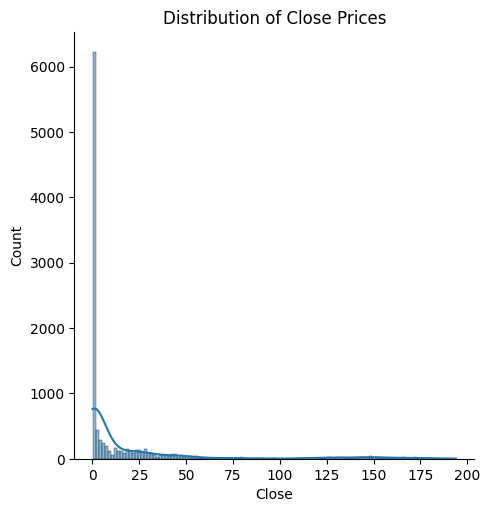

In [13]:
plt.figure(figsize=(10, 6))

# Distribution of the target variable
sns.displot(data=df, x='Close', kde=True)
plt.title('Distribution of Close Prices')
plt.show()

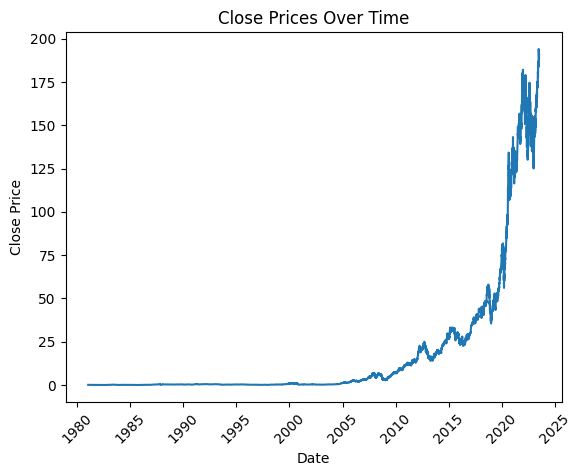

In [14]:
# Line plot of close prices over time
sns.lineplot(data=df, x='Date', y='Close')
plt.title('Close Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.xticks(rotation=45)
plt.show()

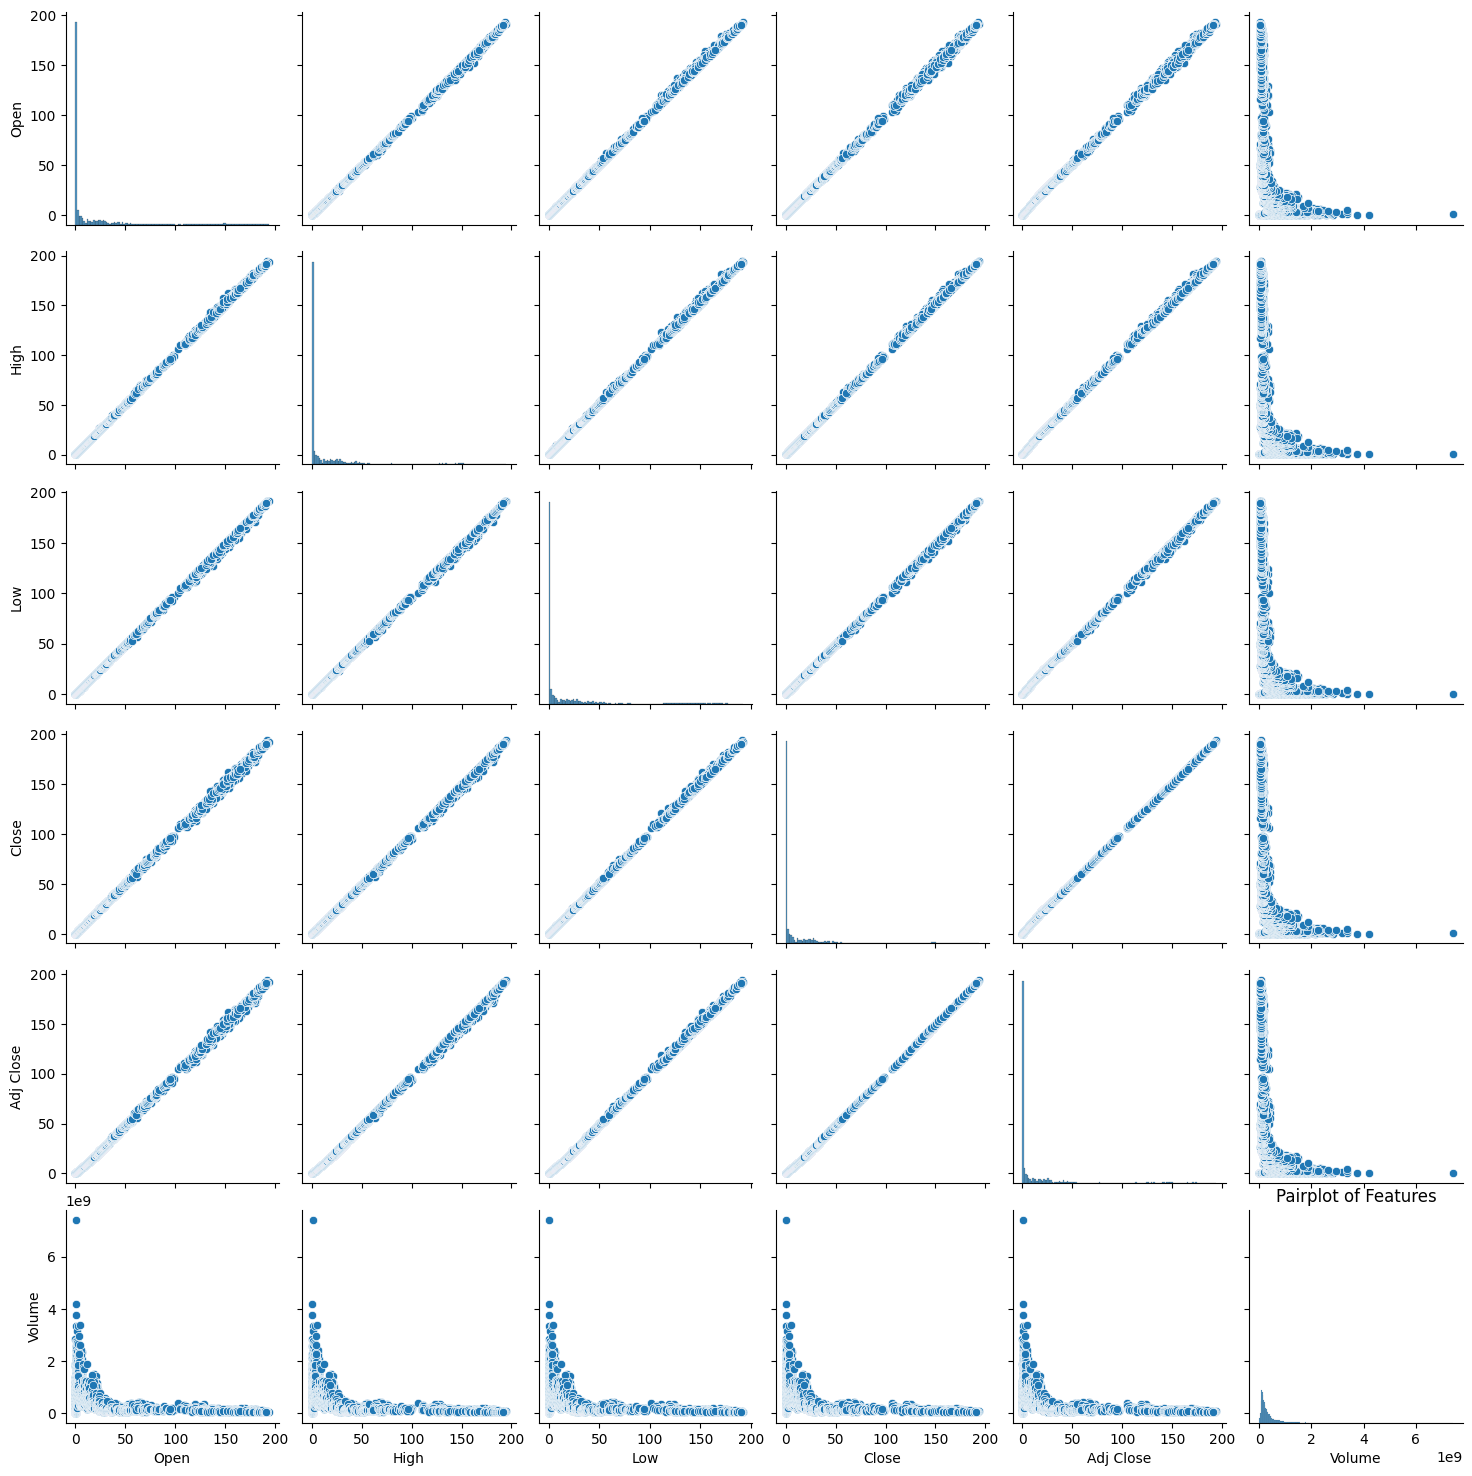

In [15]:
# Pairplot of features
sns.pairplot(data=df, vars=['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'])
plt.title('Pairplot of Features')
plt.show()

<ipython-input-16-529fc84175b4>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), cmap='coolwarm', annot=True)


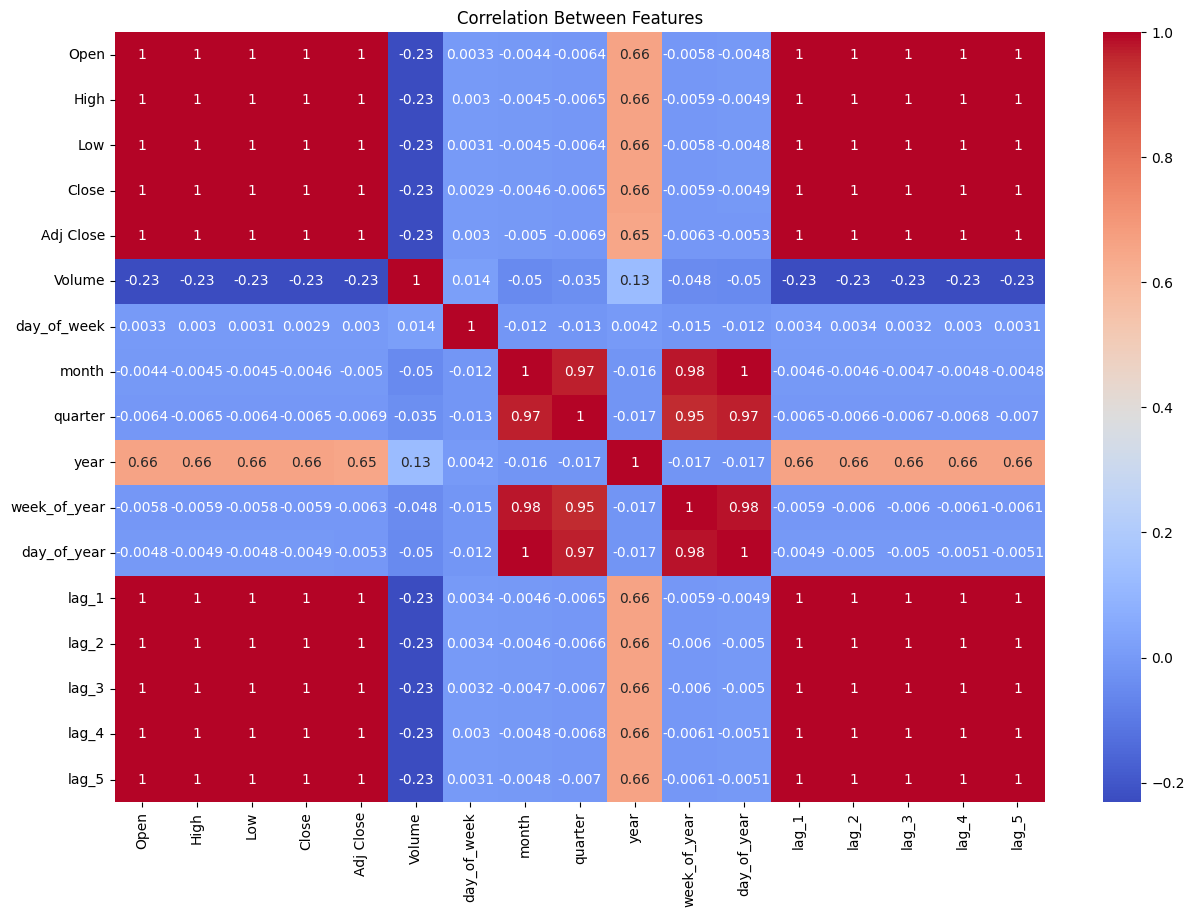

In [16]:
# Heatmap of correlation between features
plt.figure(figsize=(15, 10))
sns.heatmap(df.corr(), cmap='coolwarm', annot=True)
plt.title('Correlation Between Features')
plt.show()

Observations:
<ul>
<ol>Distribution plot of Close Prices</ol>
<li>Indicates that the majority of the Close Prices are in the range of 0 to 35.</li>
<li>Significant skewed to the right</li>
<ol>Line plot of Close Prices over time</ol>
<li>Shows how the Close Prices have changed over time</li>
<li>Indicates that there has been significant fluctuation in the Close Prices, with a few major peaks and troughs from 2005</li>
<li>Price increases exponentially since 2015</li>
<ol>Pairplot of features</ol>
<li>Shows the pairwise relationships between all the features in the dataset</li>
<li>Indicates that the Open, High, Low, and Adj Close prices are strongly positively correlated with both Close price and with each other, with a positive linear relationship</li>
<li>Volume is not strongly correlated, but it can see that it decreased when prices reached 50, and stayed constant</li>
<ol>Correlation heatmap</ol>
<li>Shows the correlation between all the features in the dataset</li>
<li>Shows that the Close Price has a strong positive correlation with Open, High, Low, and Adj Close prices, but a weak negative correlation with Volume</li>
<li>Also indicates that the Open, High, Low, and Adj Close prices are highly correlated with each other</li>
</ul>

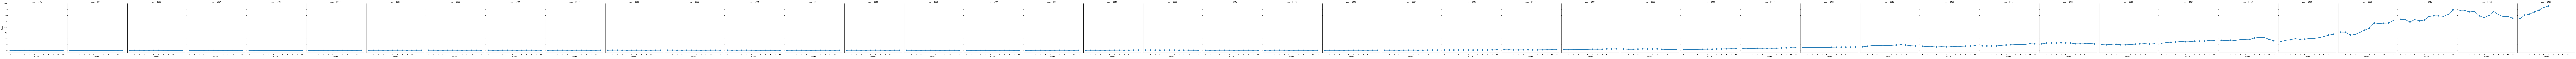

In [17]:
# Plot close price trends over months
sns.catplot(data = df, x='month', y='Close', col='year', kind="point")

In [18]:
# Check the stock open and close price data month - wise
month_wise= df.groupby('month')[['Open','Close']].aggregate('mean')
month_wise

,Open,Close
month,,
1,17.664020,17.670994
2,18.449522,18.476956
3,18.729556,18.756690
4,18.755801,18.760486
5,19.039933,19.053507
6,19.356378,19.378230
7,18.082037,18.129994
8,17.828013,17.849878
9,17.937272,17.883631


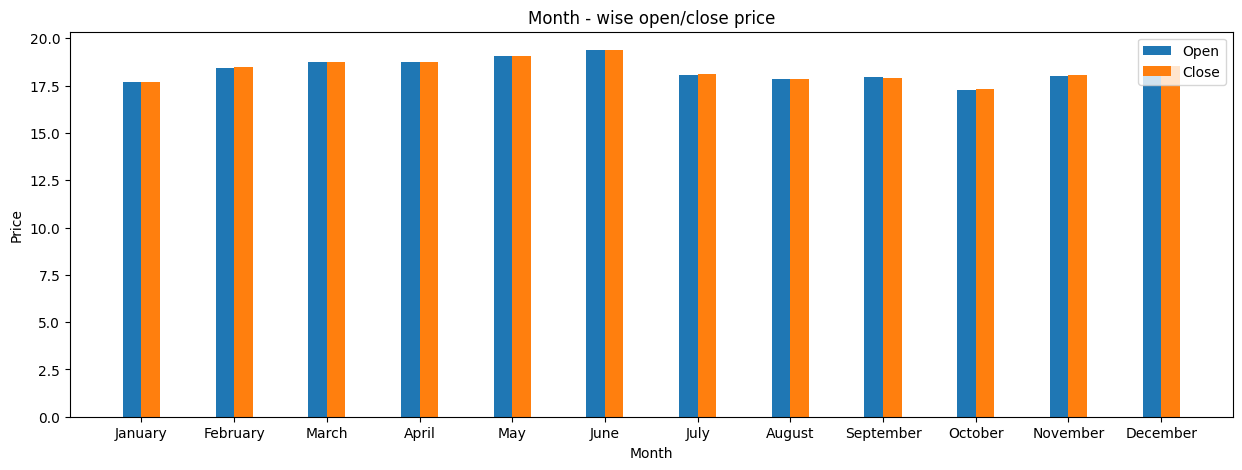

In [19]:
# Numbers of pairs of bars you want
N = month_wise.shape[0]

# Data on X-axis

# Specify the values of bars
blue_bar = month_wise['Open']
orange_bar = month_wise['Close']

# Position of bars on x-axis
ind = np.arange(N)

# Figure size
plt.figure(figsize=(15,5))

# Width of a bar
width = 0.2

# Plotting
plt.bar(ind, blue_bar , width, label='Open')
plt.bar(ind + width, orange_bar, width, label='Close')

plt.xlabel('Month')
plt.ylabel('Price')
plt.title('Month - wise open/close price')

# xticks()
# First argument - A list of positions at which ticks should be placed
# Second argument -  A list of labels to place at the given locations
plt.xticks(ind + width / 2, ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August',
             'September', 'October', 'November', 'December'])

# Finding the best position for legends and putting it
plt.legend(loc='best')
plt.show()

In [20]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df[['Open', 'High', 'Low', 'Volume']], df['Close'], test_size=0.2, random_state=42)
print('Number of records in training set: ', X_train.shape[0])
print('Number of records in testing set: ', X_test.shape[0])

Number of records in training set:  8574
Number of records in testing set:  2144


In [21]:
# Linear Regression Model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

y_pred_lr = lr_model.predict(X_test)

mse_lr = mean_squared_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mse_lr)
mae_lr = mean_absolute_error(y_test, y_pred_lr)
mape_lr = np.mean(np.abs((y_test - y_pred_lr) / y_test)) * 100
r2_lr = r2_score(y_test, y_pred_lr)

print('Linear Regression Model:')
print(f'MSE: {mse_lr:.2f}')
print(f'RMSE: {rmse_lr:.2f}')
print(f'MAE: {mae_lr:.2f}')
print(f'MAPE: {mape_lr:.2f}%')
print(f'R2 Score: {r2_lr:.2f}\n')

Linear Regression Model:
MSE: 0.09
RMSE: 0.31
MAE: 0.09
MAPE: 0.86%
R2 Score: 1.00



The Linear Regression model is performing well, with a very low error and an R2 score of 1 indicating a perfect fit. However, it is important to note that overfitting is possible and further evaluation may be necessary.

In [22]:
# Decision Tree Regression Model
dt_model = DecisionTreeRegressor()
dt_model.fit(X_train, y_train)

y_pred_dt = dt_model.predict(X_test)

mse_dt = mean_squared_error(y_test, y_pred_dt)
rmse_dt = np.sqrt(mse_dt)
mae_dt = mean_absolute_error(y_test, y_pred_dt)
mape_dt = np.mean(np.abs((y_test - y_pred_dt) / y_test)) * 100
r2_dt = r2_score(y_test, y_pred_dt)

print('Decision Tree Regression Model:')
print(f'MSE: {mse_dt:.2f}')
print(f'RMSE: {rmse_dt:.2f}')
print(f'MAE: {mae_dt:.2f}')
print(f'MAPE: {mape_dt:.2f}%')
print(f'R2 Score: {r2_dt:.2f}\n')

Decision Tree Regression Model:
MSE: 0.23
RMSE: 0.48
MAE: 0.15
MAPE: 1.08%
R2 Score: 1.00



What does this model tell us:
<ul>
<li>The Decision Tree Regression Model has a relatively high MSE, RMSE, MAE, and MAPE compared to the Linear Regression model.</li>
<li>The R2 Score is 1.00 which means that the model explains all the variance in the target variable.</li>
</ul>



In [23]:
# Random Forest Regression Model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)

mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
mape_rf = np.mean(np.abs((y_test - y_pred_rf) / y_test)) * 100
r2_rf = r2_score(y_test, y_pred_rf)

print('Random Forest Regression Model:')
print(f'MSE: {mse_rf:.2f}')
print(f'RMSE: {rmse_rf:.2f}')
print(f'MAE: {mae_rf:.2f}')
print(f'MAPE: {mape_rf:.2f}%')
print(f'R2 Score: {r2_rf:.2f}\n')

Random Forest Regression Model:
MSE: 0.15
RMSE: 0.39
MAE: 0.12
MAPE: 0.87%
R2 Score: 1.00



What does this model tell us:
<ul>
<li>The Random Forest Regression Model has a relatively low MSE, RMSE, MAE, and MAPE compared to the Decision tree model, but not as low as Linear Regression model.</li>
<li>The R2 Score is 1.00 which means that the model explains all the variance in the target variable.</li>
</ul>



In [24]:
# Support Vector Regression Model
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

svr_model = SVR(kernel='linear')
svr_model.fit(X_train_scaled, y_train)

y_pred_svr = svr_model.predict(X_test_scaled)

mse_svr = mean_squared_error(y_test, y_pred_svr)
rmse_svr = np.sqrt(mse_svr)
mae_svr = mean_absolute_error(y_test, y_pred_svr)
mape_svr = np.mean(np.abs((y_test - y_pred_svr) / y_test)) * 100
r2_svr = r2_score(y_test, y_pred_svr)

print('Support Vector Regression Model:')
print(f'MSE: {mse_svr:.2f}')
print(f'RMSE: {rmse_svr:.2f}')
print(f'MAE: {mae_svr:.2f}')
print(f'MAPE: {mape_svr:.2f}%')
print(f'R2 Score: {r2_svr:.2f}\n')

Support Vector Regression Model:
MSE: 0.21
RMSE: 0.46
MAE: 0.18
MAPE: 18.26%
R2 Score: 1.00



What does this model tell us:
<ul>
<li>The SVR model is fit to the training data using a linear kernel.</li>
<li>Based on the evaluation, the model has an RMSE of 0.46, which means that, on average, the predicted values are off by about 0.46 units.</li>
<li>The model has an MAPE of 18.26%, which means that, on average, the predicted values are off by about 18.26% of the true values.</li>
<li>The R2 score of 1.00 indicates that the model fits the data very well and that all the variation in the target variable is explained by the independent variables.</li>
<li>The performance of the model can be improved by tuning hyperparameters, trying different kernels, or using different feature engineering techniques.</li>
</ul>

In [25]:
# Create a new dataframe with only the 'Close column
data = df.filter(['Close'])

# Convert the dataframe to a numpy array
dataset = data.values

# Get the number of rows to train the model on, using 95% of the data
len_train_data = int(np.ceil( len(dataset) * .95 ))
len_train_data

10183

In [26]:
# Scale the data

mms = MinMaxScaler(feature_range=(0,1))
trained_scaled_data = mms.fit_transform(dataset)
trained_scaled_data[0:5]

array([[0.00048057],
       [0.00047481],
       [0.00044892],
       [0.00045179],
       [0.00046618]])

In [27]:
# Create the training data set

# Create the scaled training data set
train_data = trained_scaled_data[0:int(len_train_data), :]

# Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    if i<= 61:
        print(x_train)
        print(y_train)
        print()

# Convert the x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data
print('Reshaping the data to: ', (x_train.shape[0], x_train.shape[1], 1))
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

[array([0.00048057, 0.00047481, 0.00044892, 0.00045179, 0.00046618,
       0.00046042, 0.00050359, 0.00048057, 0.00049495, 0.00050359,
       0.00050071, 0.0004892 , 0.00048344, 0.00046042, 0.00043453,
       0.00039712, 0.00035971, 0.00038273, 0.00040575, 0.00040575,
       0.00040863, 0.0003741 , 0.0003741 , 0.00035395, 0.00034819,
       0.00033381, 0.00034819, 0.0003741 , 0.00033668, 0.00030503,
       0.00031366, 0.00029352, 0.00032805, 0.00033668, 0.00035683,
       0.00035971, 0.00035108, 0.00034532, 0.00034244, 0.00033668,
       0.00029064, 0.00026474, 0.0002446 , 0.00026474, 0.00025899,
       0.00027913, 0.00030503, 0.00033956, 0.00033381, 0.00033956,
       0.00036259, 0.00035971, 0.00034819, 0.00033668, 0.00031654,
       0.00031654, 0.00031079, 0.00030503, 0.00035395, 0.00035683])]
[0.0003453160648073332]

[array([0.00048057, 0.00047481, 0.00044892, 0.00045179, 0.00046618,
       0.00046042, 0.00050359, 0.00048057, 0.00049495, 0.00050359,
       0.00050071, 0.0004892 , 0.

In [28]:
# Build the LSTM model
lstm = Sequential()
lstm.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
lstm.add(LSTM(64, return_sequences=False))
lstm.add(Dense(25))
lstm.add(Dense(1))

# Compile the model
lstm.compile(optimizer='adam', loss='mean_squared_error')
print('Model Summary: ')
print(lstm.summary())

# Train the model
lstm.fit(x_train, y_train, batch_size=32, epochs=25)

Model Summary: 
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 128)           66560     
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 25)                1625      
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 117,619
Trainable params: 117,619
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/25
317/317 [==============================] - 51s 146ms/step - loss: 2.2088e-04
Epoch 2/25
317/317 [==============================] - 47s 149ms/step - lo

In [29]:
# Create the testing data set

# Create a new array containing scaled values from index 1543 to 2002
test_data = trained_scaled_data[len_train_data - 60: , :]

# Create the data sets x_test and y_test
x_test = []
y_test = dataset[len_train_data:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

# Get the models predicted price values
predictions = lstm.predict(x_test)
predictions = mms.inverse_transform(predictions)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))

# LSTM model
mse_lstm = mean_squared_error(y_test, predictions)
rmse_lstm = np.sqrt(mse_lstm)
mae_lstm = mean_absolute_error(y_test, predictions)
mape_lstm = np.mean(np.abs((y_test - predictions) / y_test)) * 100
r2_lstm = r2_score(y_test, predictions)

print('lstm Model:')
print(f'MSE: {mse_lstm:.2f}')
print(f'RMSE: {rmse_lstm:.2f}')
print(f'MAE: {mae_lstm:.2f}')
print(f'MAPE: {mape_lstm:.2f}%')
print(f'R2 Score: {r2_lstm:.2f}\n')

17/17 [==============================] - 2s 43ms/step
lstm Model:
MSE: 8.97
RMSE: 2.99
MAE: 2.29
MAPE: 1.47%
R2 Score: 0.96



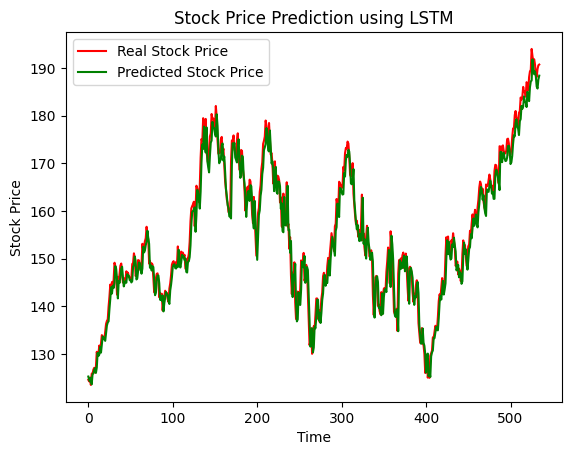

In [30]:
plt.plot(y_test, color = 'red', label = 'Real Stock Price')
plt.plot(predictions, color = 'green', label = 'Predicted Stock Price')
plt.title('Stock Price Prediction using LSTM')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

The LSTM model shows promising performance
<ul>
<li>Low prediction errors (MSE and RMSE) and relatively small deviations from the actual values (MAE).</li>
<li>The MAPE indicates a low average percentage difference, suggesting accurate predictions in relative terms.</li>
<li>The high R2 score indicates a strong relationship between the predictors and the target variable, indicating a good fit of the model to the data.</li>
</ul>

In [31]:
models = ['Linear Regression', 'Decision Tree Regression', 'Random Forest Regression', 'Support Vector Regression', 'LSTM']

mse = [mse_lr, mse_dt, mse_rf, mse_svr, mse_lstm]
rmse = [rmse_lr, rmse_dt, rmse_rf, rmse_svr, rmse_lstm]
mae = [mae_lr, mae_dt, mae_rf, mae_svr, mae_lstm]
mape = [mape_lr, mape_dt, mape_rf, mape_svr, mape_lstm]
r2 = [r2_lr, r2_dt, r2_rf, r2_svr, r2_lstm]

# Create a dataframe to store the evaluation metrics
eval_metrics_df = pd.DataFrame({'Model': models, 'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'MAPE': mape, 'R2 Score': r2})
eval_metrics_df.set_index('Model', inplace=True)
eval_metrics_df

,MSE,RMSE,MAE,MAPE,R2 Score
Model,,,,,
Linear Regression,0.094155,0.306848,0.089129,0.855995,0.999937
Decision Tree Regression,0.234766,0.484526,0.148316,1.079799,0.999842
Random Forest Regression,0.151655,0.389430,0.123567,0.865616,0.999898
Support Vector Regression,0.210624,0.458938,0.180111,18.264499,0.999859
LSTM,8.969153,2.994854,2.292315,1.474728,0.960441


# References
<ul>
<li>https://uk.finance.yahoo.com/quote/AAPL/history?p=AAPL&guccounter=2</li>
</ul>